In [64]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from itertools import combinations, product
from statistics import mean
from sklearn.feature_selection import f_classif
import itertools

First, we will read in and clean the data. 

In [65]:
def clean_data(penguins):
    """
    Cleans the penguins data. 
    """
    # Dropping unneeded columns and rows
    penguins = penguins.drop(['studyName', 'Sample Number', 'Individual ID', 
                              'Date Egg', 'Comments', 'Region'], axis = 1)
    penguins = penguins.dropna()

    # Recoding and cleaning Sex column
    recode1 = {"MALE"  : 0, "FEMALE" : 1, "." : 2}
    penguins["Sex"] = penguins["Sex"].map(recode1)
    penguins = penguins[penguins['Sex'] != 2]

    # Recoding Island column
    recode2 = {'Biscoe'  : 0, 'Dream' : 1, 'Torgersen'  : 3}
    penguins["Island"] = penguins["Island"].map(recode2)
    
    # Cleaning species column
    penguins["Species"] = penguins["Species"].str.split().str.get(0)
    
    le = preprocessing.LabelEncoder()
    #stage
    penguins['Stage'] = le.fit_transform(penguins['Stage'])
    #clutch competition
    penguins['Clutch Completion'] = le.fit_transform(penguins['Clutch Completion'])

    
    return penguins

In [66]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)
myData = penguins
penguins = clean_data(penguins)


In [67]:
penguins.head()

,Species,Island,Stage,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
1,Adelie,3,0,1,39.5,17.4,186.0,3800.0,1,8.94956,-24.69454
2,Adelie,3,0,1,40.3,18.0,195.0,3250.0,1,8.36821,-25.33302
4,Adelie,3,0,1,36.7,19.3,193.0,3450.0,1,8.76651,-25.32426
5,Adelie,3,0,1,39.3,20.6,190.0,3650.0,0,8.66496,-25.29805
6,Adelie,3,0,0,38.9,17.8,181.0,3625.0,1,9.18718,-25.21799


# Exploratory Figures and Table
In this next section, we are going to use tables and figures to get a first look into seeing what columns we might want to use to train our model.

## Figure 1

Text(0.5, 0.98, 'Culmen Depth vs Culmen Length')

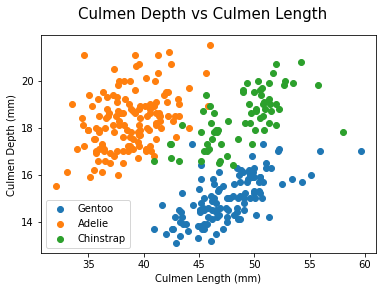

In [68]:
fig, ax = plt.subplots(1)
species = set(penguins['Species'])

for s in species:
    i = penguins[penguins['Species'] == s]
    ax.scatter(i['Culmen Length (mm)'], i['Culmen Depth (mm)'], label = s)
    
ax.legend()

ax.set(xlabel = 'Culmen Length (mm)',
       ylabel = 'Culmen Depth (mm)')

fig.suptitle('Culmen Depth vs Culmen Length', fontsize=15)

This scatter plot tells us that culmen depth and culmen length correlation for each species. We can see that relative to the other penguins, the Chinstrap penguins have a high culmen length and depth, Gentoo penguins have a low culmen depth but high culmen length, and the Adelie penguins have a high culmen depth but low culmen length. This figure shows us that culmen depth and culmen length may good columns to use as there each species is grouped up and can be somewhat separated with these two qualities. 

## Figure 2

""


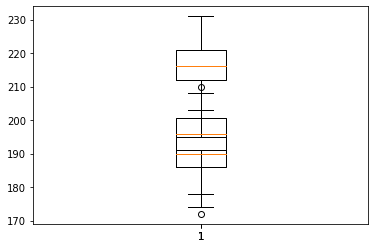

In [69]:
fig, ax = plt.subplots(1)

def plot_box(df):
    ax.boxplot(df['Flipper Length (mm)'])

penguins.groupby("Species").apply(plot_box)

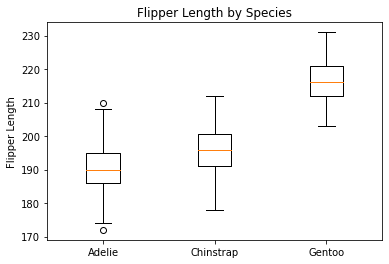

In [70]:
ad = penguins[penguins["Species"] == "Adelie"]["Flipper Length (mm)"] # 190
ch = penguins[penguins["Species"] == "Chinstrap"]["Flipper Length (mm)"] # 2
ge = penguins[penguins["Species"] == "Gentoo"]["Flipper Length (mm)"] # 3, tallest

fig, ax = plt.subplots(1)

bp = ax.boxplot([ad, ch, ge])
l = ax.set(ylabel = "Flipper Length", title = "Flipper Length by Species")
xl = plt.xticks([1, 2, 3], ["Adelie", "Chinstrap", "Gentoo"])

Though we ended up using the column combination of Island, Culmen Length, and Culmen Depth, as the output of the top 10 best column combinations showed, there were other options that we could have chosen. One of the columns that showed up repeatedly as a good predictors of species (that we did not end up using) was Flipper Length. In this boxplot graph, I examined how well Flipper Length can predict Species. As you can see in the results, knowing a penguin's flipper length can likely help in determining whether or not a penguin is of the Gentoo species. However, Flipper Length would not be that helpful in determining whether or not a pegnuin belongs to the Adelie or Chinstrap species.  

## Figure 3

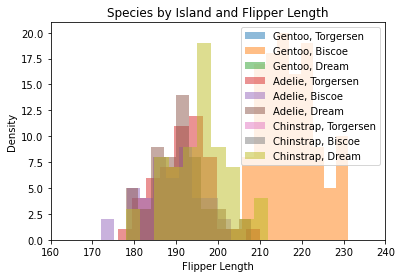

In [71]:
myData["Species"] = myData["Species"].str.split().str.get(0)

fig.set_figheight(15)
fig.set_figwidth(10)

fig, ax = plt.subplots(1)
species = set(myData['Species'])
location = set(myData['Island'])

ax.set(xlabel = 'Flipper Length', 
       ylabel = 'Density', 
       title = 'Species by Island and Flipper Length')

for s in species: 
    i = myData[myData['Species'] == s]
    for l in location:
        t = i[i['Island'] == l]
        ax.hist(t['Flipper Length (mm)'], label = str(s) + ', ' + str(l) , alpha = 0.5)
        ax.set_xlim([160,240])

ax.legend()

This graph shows us the correlation between the flipper length of each species on seperated by island. However this graph is really convoluted and we cannot see the data clearly.

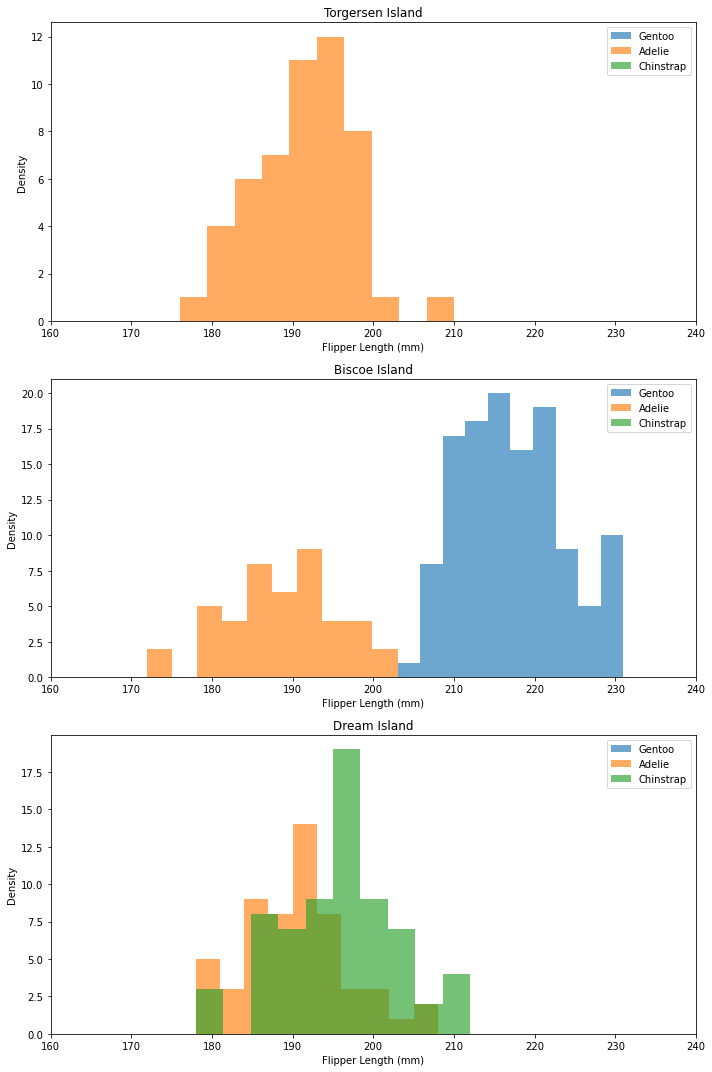

In [72]:
fig, ax = plt.subplots(3)
species = set(myData['Species'])
location = set(myData['Island'])

fig.set_figheight(15)
fig.set_figwidth(10)

count = 0
for l in location: 
   
    for s in species:
        i = myData[myData['Species'] == s]
        t = i[i['Island'] == l]
        ax[count].hist(t['Flipper Length (mm)'], label = str(s), alpha = 0.65)
    ax[count].legend()
    ax[count].set(xlabel = 'Flipper Length (mm)', ylabel = 'Density')
    ax[count].set_title(str(l) + ' Island')
    ax[count].set_xlim([160,240])
    count += 1
plt.tight_layout()

When we seperate the penguins by island, we are able to get a clearer view of what penguin is where. We can see that Adelie penguin is on all 3 islands. However the Chinstrap is only on Dream island, and the Gentoo is only on Biscoe. As the Adelie is on all 3 islands, we can see that its flipper length remains the relatively the same on each island. However, factors such as competition will cause changes the bell curve. There is more of a spread on Biscoe where the Adelie must compete with the larger Gentoo. We can also see that the Adelie and Chinstrap have are similar in size so the bell curve remains tight. These graphs can tell us that island may be able to help us predict the species. The flipper length will also be able to help differentiate the Gentoo from the other two but the Adelie and Chinstrap are relatively the same size. 

## Table Part 1

In [73]:
my_col = penguins[[ 'Species','Stage', 'Clutch Completion', 'Sex', 'Body Mass (g)']]
my_col.describe()

,Stage,Clutch Completion,Sex,Body Mass (g)
count,324.0,324.000000,324.000000,324.000000
mean,0.0,0.895062,0.503086,4213.966049
std,0.0,0.306948,0.500764,809.277529
min,0.0,0.000000,0.000000,2700.000000
25%,0.0,1.000000,0.000000,3550.000000
50%,0.0,1.000000,1.000000,4050.000000
75%,0.0,1.000000,1.000000,4800.000000
max,0.0,1.000000,1.000000,6300.000000


In this table, we are looking at the chart characteristics "Stage", "Clutch Completion", "Sex", "Body Mass(g)". From this chart we can sese that the column "Stage" would be a terrible factor to consider as it does not provide any data to help differentiate the species. The min and max are the same value. This means the only value in the column is the value 0, which represents the adult penguins. This column only shows that all the penguins are adults and does not help differentiate the species. For sex, it seems that the amount of male and female penguins is evenly distributed and that shows none of the penguin species are skewed a certain way. From this, we could conclude that sex would not be a good factor to include in our comparison. For clutch completion the data binarized and it does seem to be skewed toward. This might show that one species may have a high clutch completion. Therefore, compared to the other factors, this would be a stronger indicator of species. Last we have the body mass. The body mass might be the best indicator because it has the highest standard deviation. We can assume that this is due to the different species being different sizes. The body mass column is different from the other columns as the data is numerical and not just binarized. The more nunanced information will allow our models to be more specific. Overall, from this table we can infer that body mass and clutch completition will be strong indicators of species while stage and sex will not be as helpful. 

## Table Part 2

In [74]:
my_col.groupby('Species').aggregate([np.mean, np.std])

Stage      Clutch Completion                 Sex            \
           mean  std              mean       std      mean       std   
Species                                                                
Adelie        0  0.0          0.906475  0.292220  0.510791  0.501691   
Chinstrap     0  0.0          0.791045  0.409631  0.507463  0.503718   
Gentoo        0  0.0          0.940678  0.237234  0.491525  0.502060   

          Body Mass (g)              
                   mean         std  
Species                              
Adelie      3702.697842  460.167844  
Chinstrap   3729.850746  386.300411  
Gentoo      5091.101695  503.402158

The table above is similar to the previous table as we are looking at some statistics about the "Stage", "Clutch Completion", "Sex", "Body Mass(g)" columns. However here we have the data grouped by the species. The table above supports our some previous inferences. This table repeats that the stage shows no data at all as all penguins are at the same stage of life. The sex distribution between each species is very similar and lack any difference. We were also correct that body mass has more defined differences between each species. With the clutch completion, the data shows that this factor is stronger the stage and sex but not as strong for the body mass. 

# Finding the ideal combination using sklearn
We are now going to find the ideal combination of columns with the tools from our sklearn kit. 

In [75]:
#getting all possible combinations

names = list(penguins.columns)[1:]
combos = list(combinations(names, 3))

combos[1:6]

[('Island', 'Stage', 'Culmen Length (mm)'),
 ('Island', 'Stage', 'Culmen Depth (mm)'),
 ('Island', 'Stage', 'Flipper Length (mm)'),
 ('Island', 'Stage', 'Body Mass (g)'),
 ('Island', 'Stage', 'Sex')]

In [76]:
#list to hold the scores
dtm_score = []
lrm_score = []
mlpm_score = []

#lists to hold depths and complexities
t_depth = []
lr_c = []
mlp_depths = []

## Training Data using Decision Tree

In [77]:
#using tree to select cols for using decision tree
def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices
    """
    T = tree.DecisionTreeClassifier(max_depth = 5)
    return cross_val_score(T, x_train[cols], y_train, cv = 5).mean()  


def test_column_score(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices
    """
    cols = list(tupCol)
    T = tree.DecisionTreeClassifier(max_depth = 5)
    T.fit(x_train[cols], y_train)
    return T.score(x_test[cols], y_test)

In [78]:
#functions to find the best depths and complexities for each model
def tree_best_depth(): 
    '''
    prints a graph showing the depth for a decision tree model
    returns the best depth and training score
    '''
    fig, ax = plt.subplots(1, figsize = (10, 7))
    best_score = 0
    for d in range(1,30):
        T = tree.DecisionTreeClassifier(max_depth = d)
        cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
        ax.scatter(d, cv_score, color = "black")

        if cv_score > best_score:
            best_depth = d
            best_score = cv_score

    l = ax.set(title = "Best Depth : " + str(best_depth),
           xlabel = "Depth", 
           ylabel = "CV Score")
    return best_depth, best_score

def best_complex():
    '''
    prints a graph showing the complexity for a logistic regression model
    returns the best complexity and training score
    '''
    #test best complexity for logistic regresssion
    fig, ax = plt.subplots(1, figsize = (10, 7))
    lr_best_score = 0

    #comp is short for complexity 
    for comp in np.linspace(0.1, 2, 41):
        #range(1,30)
        logreg = LogisticRegression(max_iter = 1000, C = comp)
        cv_score = cross_val_score(logreg, X_train, y_train, cv=10).mean()
        ax.scatter(comp, cv_score, color = "black")

        if cv_score > lr_best_score:
            best_comp = comp
            lr_best_score = cv_score


    l = ax.set(title = "Best Complexity : " + str(best_comp),
           xlabel = "Complexity", 
           ylabel = "CV Score")
    
    return best_comp, best_score

def mlp_depth():
    '''
    prints a graph showing the depth for a MLP model
    returns the best depth and training score
    '''
    fig, ax = plt.subplots(1)
    mlp_best_score = 0

    # For 30 depths, find the highest score to find the best depth
    for d in range(1,30):
        clf = MLPClassifier(hidden_layer_sizes=(d, d, d), max_iter=3000)
        cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
        ax.scatter(d, cv_score, color = "black")
        if cv_score > mlp_best_score:
            mlp_best_depth = d
            mlp_best_score = cv_score

    l = ax.set(title = "Best Depth : " + str(mlp_best_depth),
    xlabel = "Depth",
    ylabel = "CV Score")
    
    return mlp_best_depth, mlp_best_score

In [79]:
# Splitting the data into test and training data
train, test = train_test_split(penguins, test_size = 0.3)
train.shape, test.shape

x_train = train.drop(['Species'], axis = 1)
y_train = train['Species'].values

x_test = test.drop(['Species'], axis = 1)
y_test = test['Species'].values

In [80]:
# Dict with cross value score of each combination 
D = {}

for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_score(cols)
    D[i] = x

In [81]:
# Sorts D and shows the top 10 column combinations 
L = list(D.items())
L.sort(key = lambda tup: tup[1], reverse = True)

#show 10 best scores
best = L[0:10]

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 15
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.97353
Test score is: 0.9898
---- 18
('Island', 'Culmen Length (mm)', 'Sex'), Score: 0.97333
Test score is: 0.9898
---- 16
('Island', 'Culmen Length (mm)', 'Flipper Length (mm)'), Score: 0.96899
Test score is: 0.95918
---- 86
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.96464
Test score is: 0.9898
---- 90
('Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)'), Score: 0.96464
Test score is: 0.90816
---- 85
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.96454
Test score is: 0.95918
---- 88
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)'), Score: 0.96019
Test score is: 0.95918
---- 91
('Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'), Score: 0.95575
Test score is: 0.94898
---- 17
('Island', 'Culmen Length (mm)', 'Body Mass (g)'), Score: 0.95565
Test score is: 0.92857
---- 92
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo

Looking at the above output, we believe that the column combination that has both the best cross evaluation score and the best test score is the combination at the 15th row of combos, which includes Island, Culmen Length, and Culmen Depth as its columns.

In [82]:
# Getting the data that includes just out best columns (which are located at combos[15])
X_train = train[list(combos[15])]
X_test = test[list(combos[15])]

Now, we are going to use a decision tree model to try and predict penguin species. 

training score: 0.9778656126482212


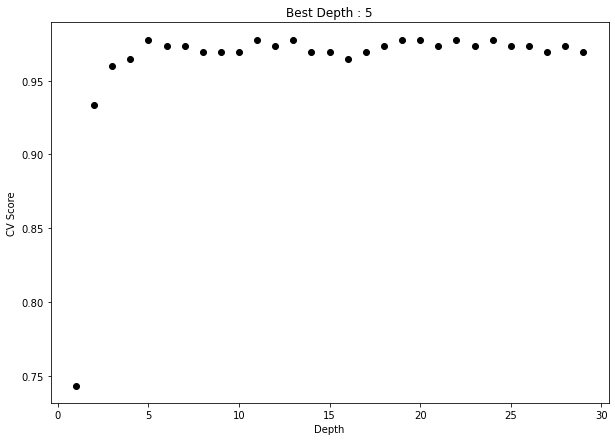

In [83]:
#tree
best_depth, best_score = tree_best_depth()
print("training score: " + str(best_score))

#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
tree_score = T.score(X_test, y_test)

In [84]:
dtm_score.append(tree_score)
t_depth.append(best_depth)
print('Test score: '+ str(tree_score))

Test score: 0.9897959183673469


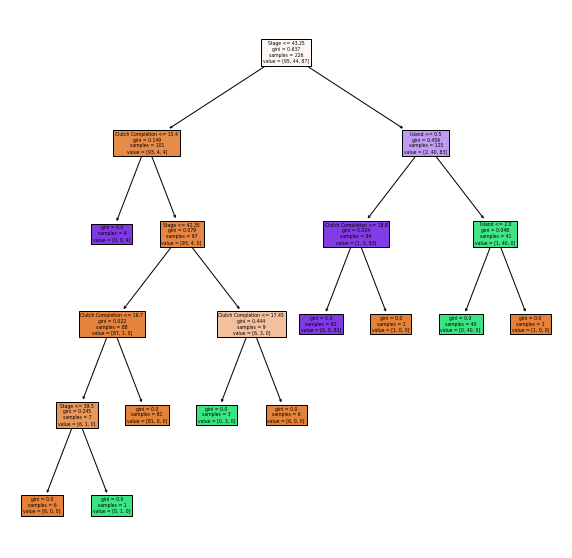

In [85]:
fig, ax = plt.subplots(1, figsize = (10, 10))
p = tree.plot_tree(T, 
                   filled = True, 
                   feature_names = penguins.drop(['Species'], axis = 1).columns)

Now, we are going to use a logistic regression model to try and predict penguin species. 

training score: 0.9778656126482212


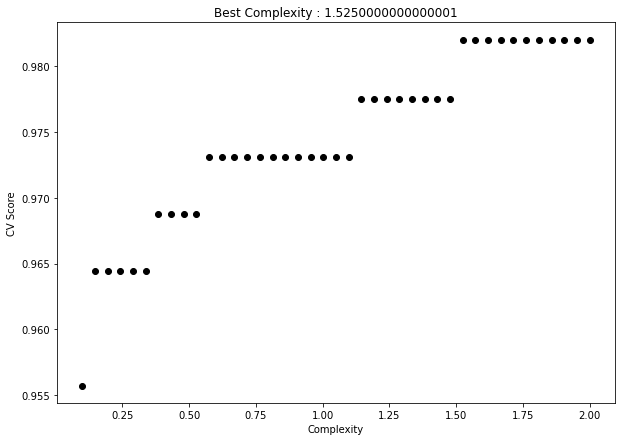

In [86]:
best_comp, best_score = best_complex()
print("training score: " + str(best_score))

#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

In [87]:
lrm_score.append(lr_score)
lr_c.append(best_comp)
print('Test score: '+ str(lr_score))

Test score: 0.9897959183673469


Now, we are going to use a multilayer perceptron classifier model to try and predict penguin species. 

training score: 18


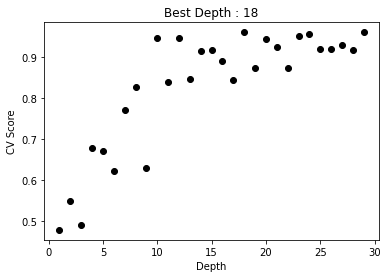

In [88]:
mlp_best_score, mlp_best_depth = mlp_depth()
print("training score: " + str(mlp_best_score))

clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
mlp_score = clf.score(X_test, y_test)

In [89]:
mlpm_score.append(mlp_score)
mlp_depths.append(mlp_best_depth)
print("Test Score: " + str(mlp_score))

Test Score: 0.9897959183673469


## Training Data with Logistic Regression 

In [90]:
#functions to train data using logistric regression
def check_column_scorecv(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices using logistic regression
    """
    logreg = LogisticRegression(max_iter = 1000)
    return cross_val_score(logreg, x_train[cols], y_train, cv = 5).mean()

def test_column_scorecv(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices with logistic regreesion
    """
    cols = list(tupCol)
    logreg = LogisticRegression(max_iter = 1000)
    logreg.fit(x_train[cols], y_train)
    return logreg.score(x_test[cols], y_test)

In [91]:
E = {}
for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_scorecv(cols)
    E[i] = x

In [92]:
M = list(E.items())
M.sort(key = lambda tup: tup[1], reverse = True)

best = M

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_scorecv(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 86
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.99556
Test score is: 0.97959
---- 89
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 0.99556
Test score is: 0.97959
---- 87
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'), Score: 0.99111
Test score is: 0.9898
---- 88
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)'), Score: 0.98222
Test score is: 1.0
---- 93
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.98222
Test score is: 0.94898
---- 17
('Island', 'Culmen Length (mm)', 'Body Mass (g)'), Score: 0.97778
Test score is: 0.93878
---- 85
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.97778
Test score is: 0.9898
---- 92
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)'), Score: 0.97778
Test score is: 0.92857
---- 94
('Culmen Length (mm)', 'Body Mass (g)', 'Sex'), Score: 0.97778
Test score is: 0.94898
---- 99
('Culmen Length (mm)', 'Delta 15 N 

Test score is: 0.7449
---- 6
('Island', 'Stage', 'Delta 15 N (o/oo)'), Score: 0.79188
Test score is: 0.71429
---- 71
('Clutch Completion', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.78763
Test score is: 0.76531
---- 36
('Stage', 'Clutch Completion', 'Culmen Length (mm)'), Score: 0.78754
Test score is: 0.71429
---- 46
('Stage', 'Culmen Length (mm)', 'Sex'), Score: 0.78754
Test score is: 0.72449
---- 72
('Clutch Completion', 'Culmen Depth (mm)', 'Sex'), Score: 0.78338
Test score is: 0.72449
---- 51
('Stage', 'Culmen Depth (mm)', 'Sex'), Score: 0.78329
Test score is: 0.72449
---- 33
('Island', 'Sex', 'Delta 15 N (o/oo)'), Score: 0.78309
Test score is: 0.71429
---- 117
('Body Mass (g)', 'Sex', 'Delta 13 C (o/oo)'), Score: 0.78309
Test score is: 0.7449
---- 9
('Island', 'Clutch Completion', 'Culmen Depth (mm)'), Score: 0.77894
Test score is: 0.71429
---- 111
('Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)'), Score: 0.77894
Test score is: 0.71429
---- 81
('Clutch Completion'

In [93]:
#testing models 
X_train = train[list(combos[89])]
X_test = test[list(combos[89])]

training score: 0.9687747035573123


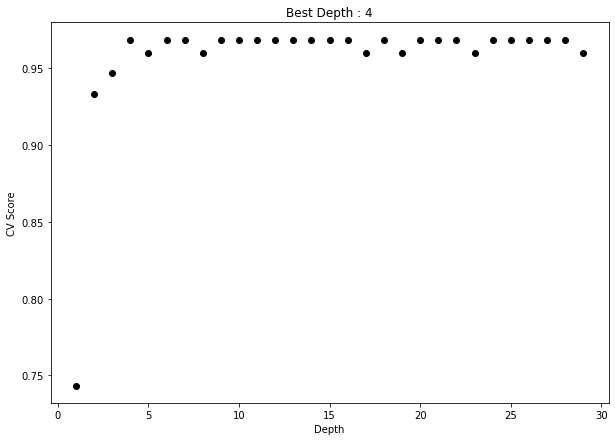

In [94]:
#tree
best_depth, best_score = tree_best_depth()
print("training score: " + str(best_score))

#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
tree_score = T.score(X_test, y_test)

In [95]:
dtm_score.append(tree_score)
t_depth.append(best_depth)
print('Test Score: )' + str(tree_score))

Test Score: )0.9489795918367347


training score: 0.9687747035573123


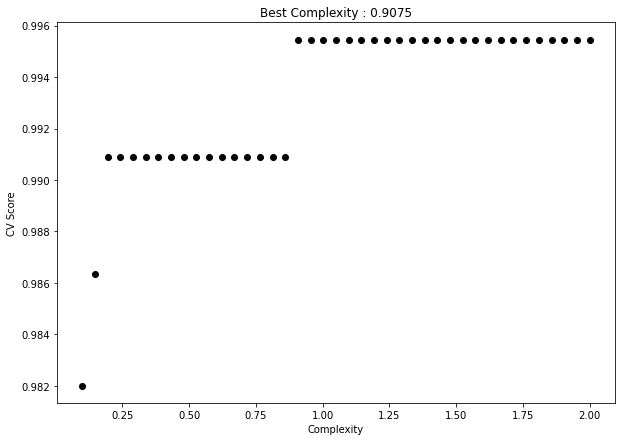

In [96]:
#logistic regression
best_comp, best_score = best_complex()
print("training score: " + str(best_score))

#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

In [97]:
lrm_score.append(lr_score)
lr_c.append(best_comp)
print('Test score: '+ str(lr_score))

Test score: 0.9795918367346939


training score: 22


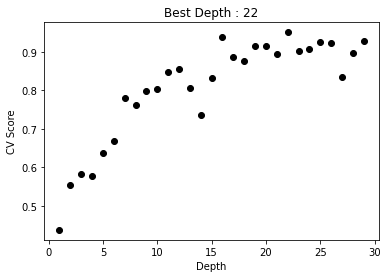

In [98]:
#multilayer perception model
mlp_best_score, mlp_best_depth = mlp_depth()
print("training score: " + str(mlp_best_score))

clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
mlp_score = clf.score(X_test, y_test)

In [99]:
mlpm_score.append(mlp_score)
mlp_depths.append(mlp_best_depth)
print("Test Score: " + str(mlp_score))

Test Score: 0.9693877551020408


## Selecting Features Using High Feature Method

In [100]:
threshold = 5 # the number of most relevant features
high_score_features = []
feature_scores = f_classif(x_train, y_train)[0]
for score, f_name in sorted(zip(feature_scores, x_train.columns), reverse=True)[:threshold]:
      print(f_name, score)
      high_score_features.append(f_name)

Stage nan
Flipper Length (mm) 372.30696108867085
Culmen Length (mm) 255.0538925833613
Culmen Depth (mm) 231.33052162697155
Body Mass (g) 229.29561152516797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


We decided to go with the features culmen length, culmen depth and sex. We chose these features because culmen length and depth were scored highly while sex is a binarized characteristic and we wanted to see it's effectiveness. 

In [101]:
X_train = train[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']]
X_test = test[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']]

training score: 0.9778656126482215


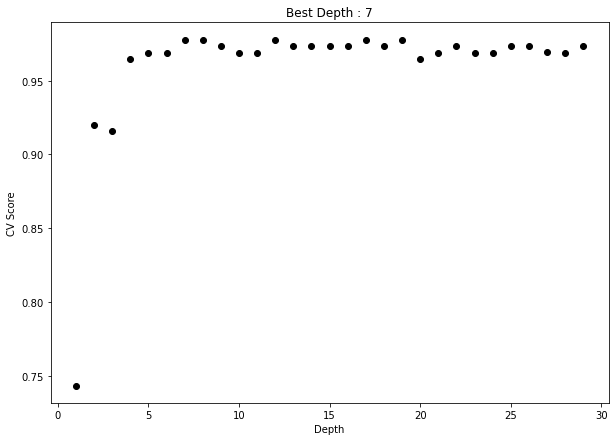

In [102]:
#tree
best_depth, best_score = tree_best_depth()
print("training score: " + str(best_score))

#decision tree model
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
tree_score = T.score(X_test, y_test)

In [103]:
dtm_score.append(tree_score)
t_depth.append(best_depth)
print('Test Score: ' + str(tree_score))

Test Score: 0.9897959183673469


training score: 0.9778656126482215


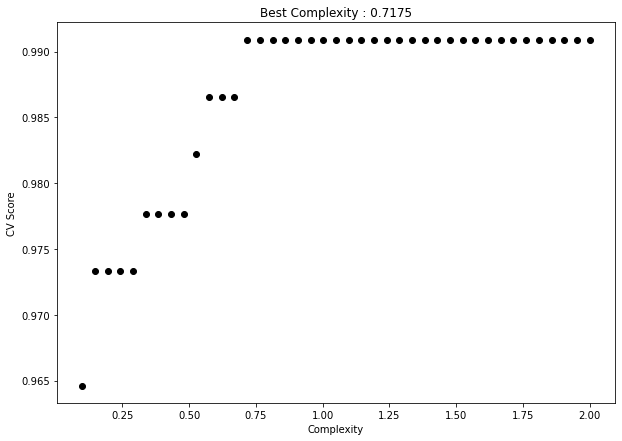

In [104]:
#logistic regression
best_comp, best_score = best_complex()
print("training score: " + str(best_score))

#training lr model
lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

In [105]:
lrm_score.append(lr_score)
lr_c.append(best_comp)
print('Test score: '+ str(lr_score))

Test score: 0.9897959183673469


In [ ]:
#multilayer perception model
mlp_best_score, mlp_best_depth = mlp_depth()
print("training score: " + str(mlp_best_score))

clf = MLPClassifier(hidden_layer_sizes=(18, 18, 18), max_iter=3000).fit(X_train, y_train)
mlp_score = clf.score(X_test, y_test)

In [ ]:
mlpm_score.append(mlp_score)
mlp_depths.append(mlp_best_depth)
print("Test Score: " + str(mlp_score))

In [ ]:
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
c = confusion_matrix(y_train, y_train_pred)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues)

Looking at the confusion matrix, we can see that there were a few penguins that were labeled wrong and it may have been due to factors such as size. This also may be due to the sex not being a strong factor.

# Contribution Statement: 
Rashi, David, and Lauren each did one model and one figure. 
Lauren made figure 1. 
Rashi made figure 2.
David made figure 3.
David made the table, parts 1 and 2. 
Rashi made the decision tree diagram and decision tree model.
David made the logistic regression model.
Lauren and Rashi made the MLP model. 
Lauren did the confusion matrix.
David did the conclusion. 
We each found a method of finding the best combination. Rashi did the decision tree cross validation, David used the logistic regression cross validation and Lauren used high feature.
Rashi and David combined all the group work together. 
We all also worked on the explanations together. 